In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:

!pip install gdown

!gdown --id 1sG2mf3SXUwQ1yJgXY8NrtrlXeAY-czww


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1sG2mf3SXUwQ1yJgXY8NrtrlXeAY-czww
From (redirected): https://drive.google.com/uc?id=1sG2mf3SXUwQ1yJgXY8NrtrlXeAY-czww&confirm=t&uuid=cc9c8bc3-4a59-474a-9b7c-4650f0447c8e
To: /content/archive (1).zip
100% 363M/363M [00:04<00:00, 87.1MB/s]


In [6]:
import zipfile

with zipfile.ZipFile('/content/archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tf_2')


In [7]:
import os

extracted_files = os.listdir('/content/tf_2')
print(extracted_files)

['seg_test', 'seg_train', 'seg_pred']


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Путь к папкам с данными
data_dir = '/content/tf_2'

In [10]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00


In [11]:
from datasets import load_dataset

# Загрузка датасета для обучения
train_dataset = load_dataset("imagefolder", data_dir=data_dir + '/seg_train')

# Загрузка датасета для тестирования
test_dataset = load_dataset("imagefolder", data_dir=data_dir + '/seg_test')

# Загрузка датасета для предсказания
pred_dataset = load_dataset("imagefolder", data_dir=data_dir + '/seg_pred')


Resolving data files:   0%|          | 0/14034 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/3000 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/7301 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
categories = {
    "buildings": 0,
    "forest": 1,
    "glacier": 2,
    "mountain": 3,
    "sea": 4,
    "street": 5,
}

In [13]:
unique_labels = set()
for example in train_dataset['train']:
    unique_labels.add(example['label'])
print(unique_labels)


{0, 1, 2, 3, 4, 5}


In [14]:


# Преобразование исходных данных в списки изображений и их соответствующих меток
train_images = []
train_labels = []
for example in train_dataset['train']:
    train_images.append(example['image'])
    train_labels.append(example['label'])

test_images = []
test_labels = []
for example in test_dataset['test']:
    test_images.append(example['image'])
    test_labels.append(example['label'])


In [15]:
# размер 100 изображения в тренировочном наборе
image = train_images[100]
image_size = image.size
print("Размер изображения:", image_size)

# размер 100 изображения в тестовом наборе
image = test_images[100]
image_size = image.size
print("Размер изображения:", image_size)

Размер изображения: (150, 150)
Размер изображения: (150, 150)


In [16]:
import numpy as np
from PIL import Image

def normalize_images(images, image_size=(150, 150)):
    normalized_images = []
    for image in images:
        resized_image = image.resize(image_size)
        normalized_image = np.array(resized_image) / 255.0
        normalized_images.append(normalized_image)
    return np.array(normalized_images)



In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Использую ImageDataGenerator и разделяю здесь на тренировочный и тестовый набор
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.1)

image_size=(224, 224)
batch_size = 32

train_set = train_datagen.flow_from_directory(directory='/content/tf_2/seg_train/seg_train',
                                               target_size=image_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               batch_size=batch_size)

val_set = test_datagen.flow_from_directory(directory='/content/tf_2/seg_test/seg_test',
                                            target_size=image_size,
                                            class_mode='categorical',
                                            shuffle=True,
                                            batch_size=batch_size)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [20]:
! pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [21]:
# Использую предварительно обученную модель EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0

In [67]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [68]:
# Заморозка весов базовой модели
base_model.trainable = False

In [127]:
x = GlobalMaxPooling2D()(base_model.output)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)

In [128]:
model = Model(inputs=base_model.input, outputs=output)

In [129]:

# Компиляция модели
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [130]:
# Вывод информации о модели
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']      

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Определение колбэков
model_checkpoint_doc_init = ModelCheckpoint(
    'model.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.3, patience=3, min_lr=1e-4)

In [132]:
history = model.fit(train_set, epochs=5,
                    validation_data=val_set,
                    callbacks=[model_checkpoint_doc_init, early_stop, reduce_lr])

Epoch 1/5
439/439 [==============================] - 842s 2s/step - loss: 1.0189 - accuracy: 0.6320 - val_loss: 0.4609 - val_accuracy: 0.7997 - lr: 0.0010
Epoch 2/5
439/439 [==============================] - 833s 2s/step - loss: 0.6379 - accuracy: 0.7579 - val_loss: 0.4588 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 3/5
439/439 [==============================] - 866s 2s/step - loss: 0.5713 - accuracy: 0.7834 - val_loss: 0.3921 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 4/5
439/439 [==============================] - 871s 2s/step - loss: 0.5378 - accuracy: 0.7978 - val_loss: 0.4078 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 5/5
439/439 [==============================] - 944s 2s/step - loss: 0.5193 - accuracy: 0.8073 - val_loss: 0.4067 - val_accuracy: 0.8420 - lr: 0.0010


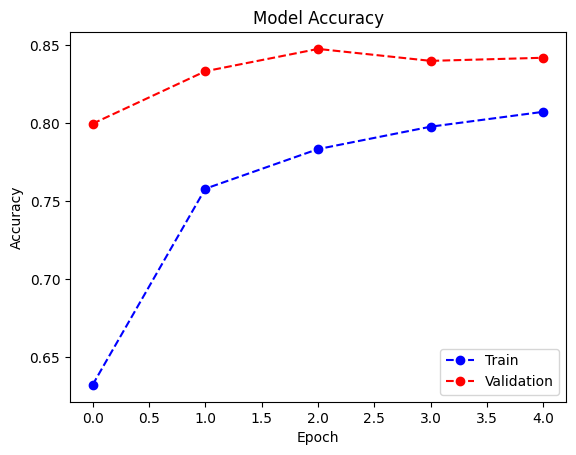

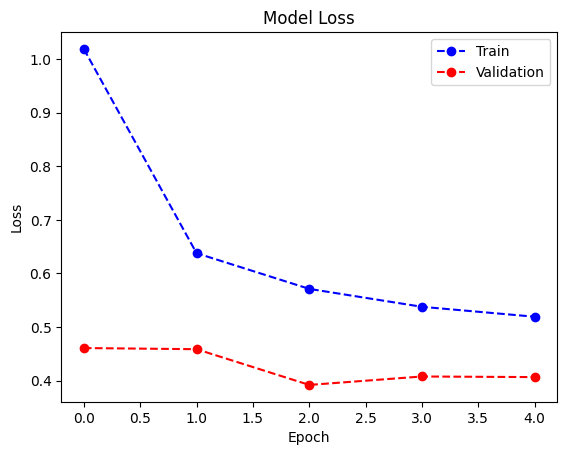

In [133]:
# визуализация метрик
plt.plot(history.history['accuracy'],'bo--', label='Train')
plt.plot(history.history['val_accuracy'],'ro--', label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'],'bo--', label='Train')
plt.plot(history.history['val_loss'],'ro--', label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

94/94 [==============================] - 143s 2s/step


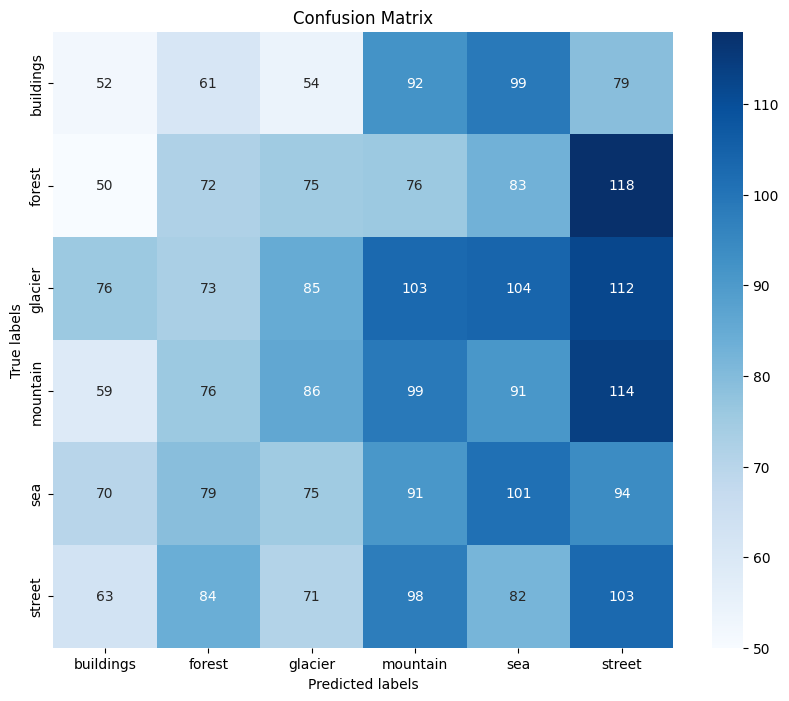

In [134]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Получение прогнозов модели для валидационного набора данных
predictions = model.predict(val_set)
predicted_classes = np.argmax(predictions, axis=1)

# Получение фактических меток
true_classes = val_set.classes

# Построение матрицы ошибок
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_set.class_indices.keys(), yticklabels=val_set.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [135]:
from sklearn.metrics import classification_report

#  отчет о классификации
report = classification_report(true_classes, predicted_classes)

print(report)


              precision    recall  f1-score   support

           0       0.14      0.12      0.13       437
           1       0.16      0.15      0.16       474
           2       0.19      0.15      0.17       553
           3       0.18      0.19      0.18       525
           4       0.18      0.20      0.19       510
           5       0.17      0.21      0.18       501

    accuracy                           0.17      3000
   macro avg       0.17      0.17      0.17      3000
weighted avg       0.17      0.17      0.17      3000



In [136]:
# Оценка производительности на тестовом наборе данных
test_loss, test_accuracy = model.evaluate(val_set)

print("Точность на тестовом наборе данных:", test_accuracy)
print("Потери на тестовом наборе данных:", test_loss)


94/94 [==============================] - 138s 1s/step - loss: 0.4067 - accuracy: 0.8420
Точность на тестовом наборе данных: 0.8420000076293945
Потери на тестовом наборе данных: 0.406698614358902


**теперь MobileNet для модели2**

In [137]:

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Загрузка предварительно обученной модели MobileNet
base_model2 = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Заморозка весов базовой модели
base_model2.trainable = False

# Добавление дополнительных слоев
x2 = GlobalAveragePooling2D()(base_model2.output)
x2 = Dense(512, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
output = Dense(6, activation='softmax')(x2)

# Создание модели
model2 = Model(inputs=base_model2.input, outputs=output)

# Компиляция модели
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Определение колбэков
model_checkpoint = ModelCheckpoint(
    'model2.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5)
# Обучение модели
history2 = model2.fit(train_set, epochs=5, validation_data=val_set, callbacks=[model_checkpoint, early_stop, reduce_lr])



17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/5
439/439 [==============================] - 680s 2s/step - loss: 0.5044 - accuracy: 0.8129 - val_loss: 0.2641 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 2/5
439/439 [==============================] - 618s 1s/step - loss: 0.3951 - accuracy: 0.8544 - val_loss: 0.2376 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 3/5
439/439 [==============================] - 668s 2s/step - loss: 0.3728 - accuracy: 0.8631 - val_loss: 0.2339 - val_accuracy: 0.9147 - lr: 0.0010
Epoch 4/5
439/439 [==============================] - 597s 1s/step - loss: 0.3492 - accuracy: 0.8712 - val_loss: 0.2280 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 5/5
439/439 [==============================] - 608s 1s/step - loss: 0.3421 - accuracy: 0.8740 - val_loss: 0.2292 - val_accuracy: 0.9153 - lr: 0.0010


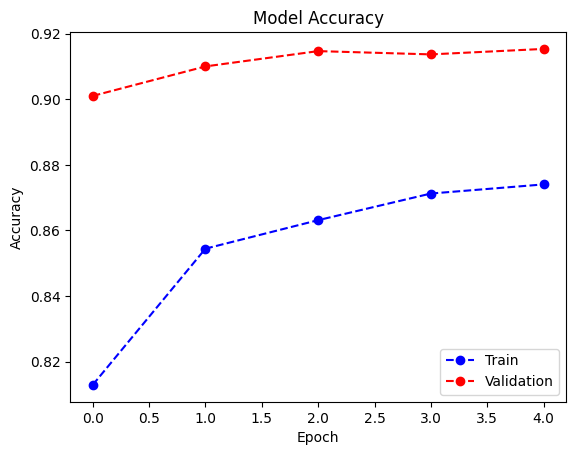

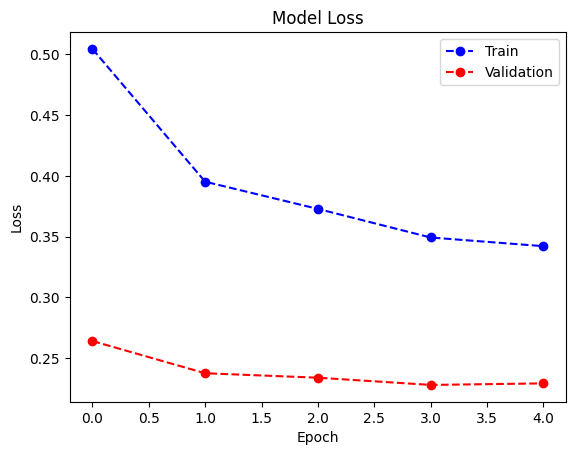

In [138]:
# визуализация метрик
plt.plot(history2.history['accuracy'],'bo--', label='Train')
plt.plot(history2.history['val_accuracy'],'ro--', label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history2.history['loss'],'bo--', label='Train')
plt.plot(history2.history['val_loss'],'ro--', label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

94/94 [==============================] - 97s 1s/step


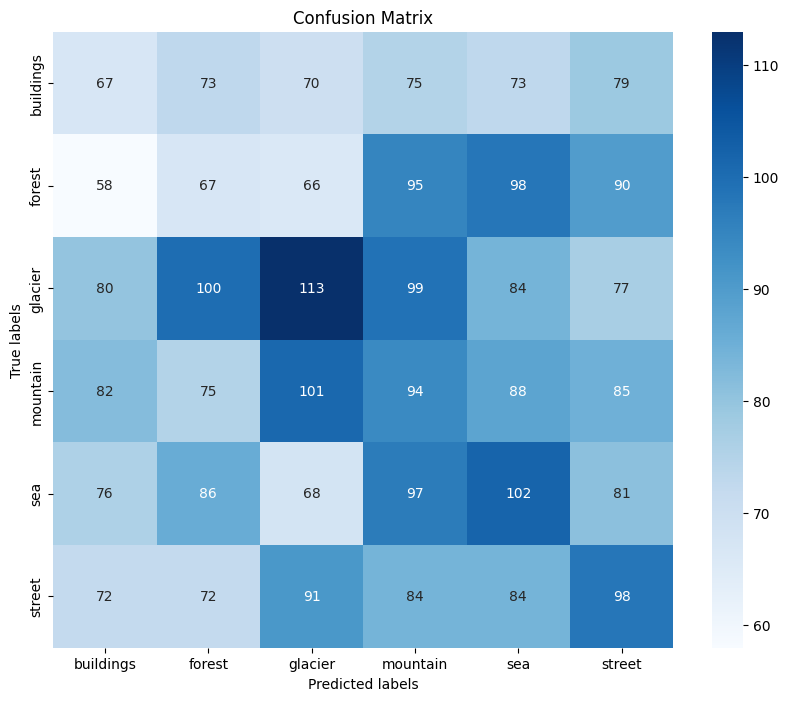

In [139]:
# Получение прогнозов модели для валидационного набора данных
predictions = model2.predict(val_set)
predicted_classes = np.argmax(predictions, axis=1)

# Получение фактических меток
true_classes = val_set.classes

# Построение матрицы ошибок
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_set.class_indices.keys(), yticklabels=val_set.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [46]:
#  отчет о классификации
report2 = classification_report(true_classes, predicted_classes)

print(report2)


              precision    recall  f1-score   support

           0       0.13      0.12      0.12       437
           1       0.17      0.17      0.17       474
           2       0.20      0.17      0.18       553
           3       0.18      0.20      0.19       525
           4       0.17      0.18      0.17       510
           5       0.14      0.16      0.15       501

    accuracy                           0.17      3000
   macro avg       0.16      0.16      0.16      3000
weighted avg       0.17      0.17      0.17      3000



In [140]:
# Оценка модели
test_loss, test_accuracy = model2.evaluate(val_set)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


94/94 [==============================] - 92s 980ms/step - loss: 0.2292 - accuracy: 0.9153
Test Loss: 0.22924722731113434
Test Accuracy: 0.9153333306312561


**добавила другие слои**

In [141]:
# Загрузка предварительно обученной модели MobileNet
base_model3 = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Заморозка весов базовой модели
base_model3.trainable = False

from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
x2 = GlobalMaxPooling2D()(base_model3.output)
x2 = Dense(1024, activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(512, activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(256, activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)

output = Dense(6, activation='softmax')(x2)
# Создание модели
model3 = Model(inputs=base_model2.input, outputs=output)

# Компиляция модели
model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Определение колбэков
model_checkpoint = ModelCheckpoint(
    'model2.keras', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5)
# Обучение модели
history3 = model3.fit(train_set, epochs=5, validation_data=val_set, callbacks=[model_checkpoint, early_stop, reduce_lr])

Epoch 1/5
439/439 [==============================] - 645s 1s/step - loss: 0.7473 - accuracy: 0.7445 - val_loss: 0.3230 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 2/5
439/439 [==============================] - 624s 1s/step - loss: 0.4925 - accuracy: 0.8242 - val_loss: 0.2870 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 3/5
439/439 [==============================] - 662s 2s/step - loss: 0.4508 - accuracy: 0.8375 - val_loss: 0.2846 - val_accuracy: 0.8937 - lr: 0.0010
Epoch 4/5
439/439 [==============================] - 604s 1s/step - loss: 0.4276 - accuracy: 0.8420 - val_loss: 0.2971 - val_accuracy: 0.8840 - lr: 0.0010
Epoch 5/5
439/439 [==============================] - 618s 1s/step - loss: 0.4264 - accuracy: 0.8471 - val_loss: 0.3054 - val_accuracy: 0.8897 - lr: 0.0010


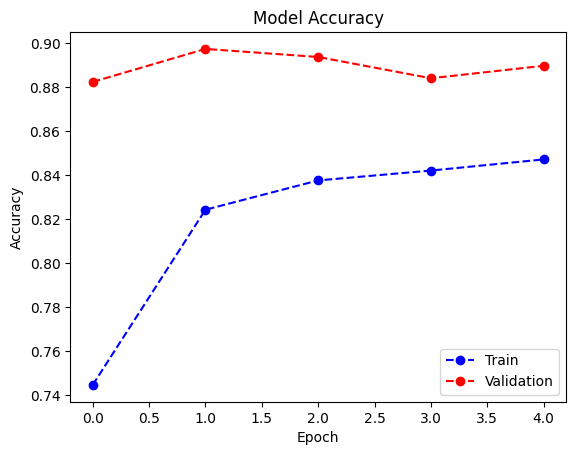

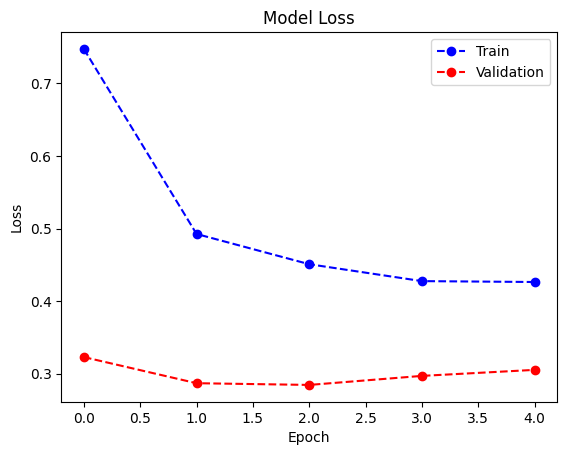

In [142]:
# визуализация метрик
plt.plot(history3.history['accuracy'],'bo--', label='Train')
plt.plot(history3.history['val_accuracy'],'ro--', label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history3.history['loss'],'bo--', label='Train')
plt.plot(history3.history['val_loss'],'ro--', label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

94/94 [==============================] - 92s 973ms/step


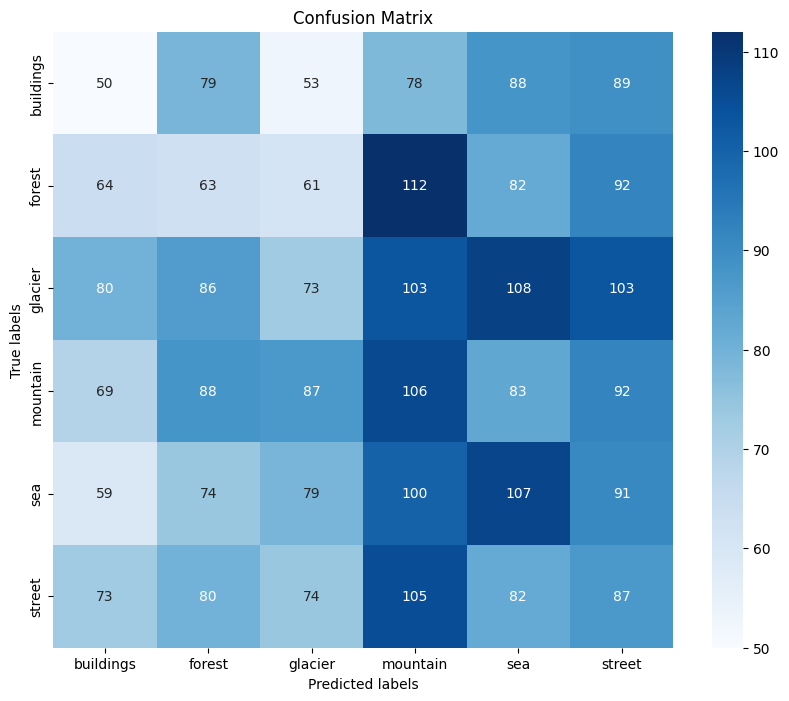

In [143]:
# Получение прогнозов модели для валидационного набора данных
predictions = model3.predict(val_set)
predicted_classes = np.argmax(predictions, axis=1)

# Получение фактических меток
true_classes = val_set.classes

# Построение матрицы ошибок
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_set.class_indices.keys(), yticklabels=val_set.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [144]:
#  отчет о классификации
report3 = classification_report(true_classes, predicted_classes)

print(report3)



              precision    recall  f1-score   support

           0       0.13      0.11      0.12       437
           1       0.13      0.13      0.13       474
           2       0.17      0.13      0.15       553
           3       0.18      0.20      0.19       525
           4       0.19      0.21      0.20       510
           5       0.16      0.17      0.16       501

    accuracy                           0.16      3000
   macro avg       0.16      0.16      0.16      3000
weighted avg       0.16      0.16      0.16      3000



In [145]:
# Оценка модели
test_loss, test_accuracy = model3.evaluate(val_set)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

94/94 [==============================] - 92s 976ms/step - loss: 0.3054 - accuracy: 0.8897
Test Loss: 0.3053796887397766
Test Accuracy: 0.8896666765213013


**Я использовала 2 модели в работе:EfficientNetB0 для модели №1 и MobileNet для модели №2. По точности лучше справилась модель №2 с минимальным количеством слоев.
EfficientNetB0: Точность на тестовом наборе данных: 0.8420000076293945
                Потери на тестовом наборе данных: 0.406698614358902

MobileNet: Test Loss: 0.22924722731113434
           Test Accuracy: 0.9153333306312561
           
В сравнении с базовой моделью (с предыдущего дз) точность увеличилась с 0.87 до 0.91         **